In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# Paths
ANNOTATIONS_DIR = r"D:\ML PROJECTS\Face Mask Detection\archive\annotations"
IMAGES_DIR = r"D:\ML PROJECTS\Face Mask Detection\archive\images"

# Helper: Parse XML
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    records = []
    filename = root.find('filename').text

    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        records.append({
            'filename': filename,
            'label': label,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })
    return records

# Collect all annotations
data = []
for file in os.listdir(ANNOTATIONS_DIR):
    if file.endswith('.xml'):
        file_path = os.path.join(ANNOTATIONS_DIR, file)
        data.extend(parse_annotation(file_path))

# Create DataFrame
df = pd.DataFrame(data)
df['filepath'] = df['filename'].apply(lambda x: os.path.join(IMAGES_DIR, x))

# Save to CSV for quick loading later
df.to_csv(r"D:\ML PROJECTS\Face Mask Detection\face_mask_labels.csv", index=False)

print("✅ Parsed and saved annotations! Total samples:", len(df))


✅ Parsed and saved annotations! Total samples: 4072


C:\Users\yuvan\AppData\Local\Temp\ipykernel_3860\4226541721.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='Set2')


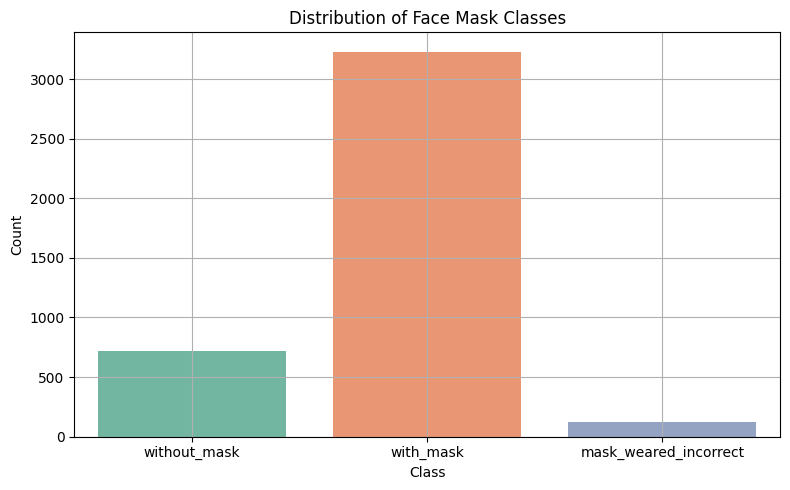

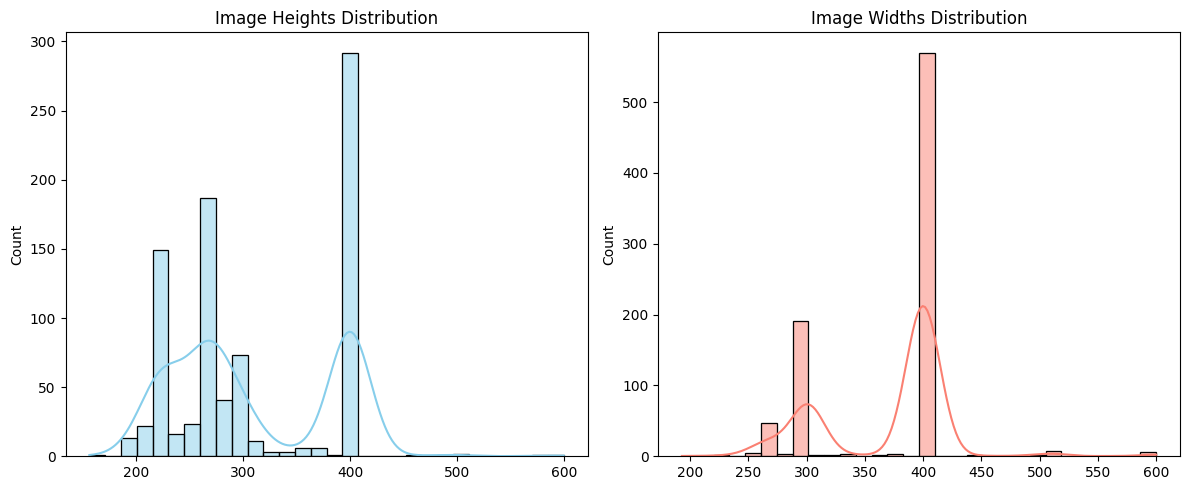

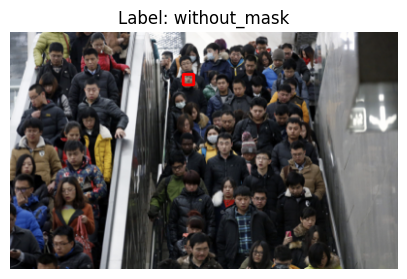

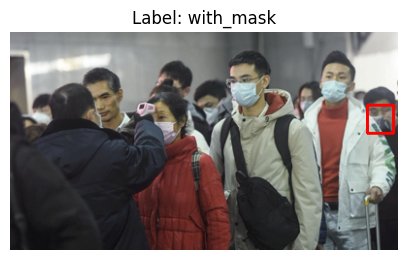

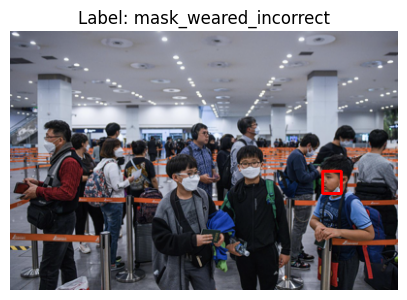

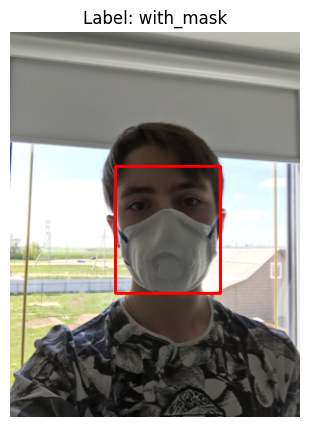

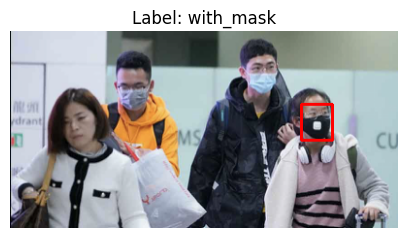

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

# Load the CSV
df = pd.read_csv(r"D:\ML PROJECTS\Face Mask Detection\face_mask_labels.csv")

# 🟦 1. Class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', palette='Set2')
plt.title("Distribution of Face Mask Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("mask_class_distribution.png")
plt.show()

# 🟩 2. Image Dimension Analysis
dims = []
for path in df['filepath'].unique():
    try:
        img = cv2.imread(path)
        if img is not None:
            dims.append(img.shape[:2])  # (height, width)
    except:
        continue

heights = [h for h, w in dims]
widths = [w for h, w in dims]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(heights, kde=True, bins=30, color="skyblue")
plt.title("Image Heights Distribution")

plt.subplot(1, 2, 2)
sns.histplot(widths, kde=True, bins=30, color="salmon")
plt.title("Image Widths Distribution")

plt.tight_layout()
plt.savefig("image_dimension_distributions.png")
plt.show()

# 🟨 3. Sample images with bounding boxes
import random

sample = df.sample(5)
for idx, row in sample.iterrows():
    image = cv2.imread(row['filepath'])
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.rectangle(image, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (255, 0, 0), 2)
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f"Label: {row['label']}")
        plt.axis('off')
        plt.show()


In [3]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load metadata
df = pd.read_csv(r"D:\ML PROJECTS\Face Mask Detection\face_mask_labels.csv")

# Label encoding
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

# Save label encoder
import pickle
with open(r"D:\ML PROJECTS\Face Mask Detection\label_encoder.pkl", 'wb') as f:
    pickle.dump(le, f)

print("✅ Labels encoded:", list(le.classes_))

# Parameters
IMG_SIZE = 128
X = []
y = []

# Crop and resize
for idx, row in df.iterrows():
    image = cv2.imread(row['filepath'])
    if image is None:
        continue

    # Crop bounding box
    face = image[row['ymin']:row['ymax'], row['xmin']:row['xmax']]
    
    if face.size == 0:
        continue

    face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    
    X.append(face)
    y.append(row['encoded_label'])

# Convert to arrays
X = np.array(X)
y = np.array(y)

# Normalize
X = X / 255.0

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Save preprocessed data
np.save(r"D:\ML PROJECTS\Face Mask Detection\X_train.npy", X_train)
np.save(r"D:\ML PROJECTS\Face Mask Detection\X_test.npy", X_test)
np.save(r"D:\ML PROJECTS\Face Mask Detection\y_train.npy", y_train)
np.save(r"D:\ML PROJECTS\Face Mask Detection\y_test.npy", y_test)

print(f"✅ Saved cropped data. X_train: {X_train.shape}, y_train: {y_train.shape}")


✅ Labels encoded: ['mask_weared_incorrect', 'with_mask', 'without_mask']
✅ Saved cropped data. X_train: (3257, 128, 128, 3), y_train: (3257,)


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Load preprocessed data
X_train = np.load(r"D:\ML PROJECTS\Face Mask Detection\X_train.npy")
X_test = np.load(r"D:\ML PROJECTS\Face Mask Detection\X_test.npy")
y_train = np.load(r"D:\ML PROJECTS\Face Mask Detection\y_train.npy")
y_test = np.load(r"D:\ML PROJECTS\Face Mask Detection\y_test.npy")

# Number of classes
num_classes = len(np.unique(y_train))

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32, callbacks=[early_stop])

# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.2f}")
print(f"✅ F1 Score: {f1:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save model
model.save(r"D:\ML PROJECTS\Face Mask Detection\mask_detector_model.h5")
print("✅ Model saved to mask_detector_model.h5")


c:\Users\yuvan\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.8401 - loss: 0.5006 - val_accuracy: 0.9294 - val_loss: 0.2257
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9331 - loss: 0.2244 - val_accuracy: 0.9371 - val_loss: 0.1923
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9410 - loss: 0.2016 - val_accuracy: 0.9325 - val_loss: 0.1822
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9358 - loss: 0.1895 - val_accuracy: 0.9310 - val_loss: 0.1672
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9406 - loss: 0.1921 - val_accuracy: 0.9294 - val_loss: 0.1764
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9425 - loss: 0.1826 - val_accuracy: 0.9340 - val_loss: 0.1909
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9362 - loss: 0.1726 - val_accuracy: 0.9387 - val_loss: 0.1699
Epoch 8/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9384 - loss: 0.1843 - val_accuracy: 0.9417 - v

✅ Accuracy: 0.95
✅ F1 Score: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.24      0.38        25
           1       0.97      0.97      0.97       647
           2       0.86      0.95      0.90       143

    accuracy                           0.95       815
   macro avg       0.89      0.72      0.75       815
weighted avg       0.95      0.95      0.94       815

✅ Model saved to mask_detector_model.h5
